In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<img src=https://i.stack.imgur.com/gyuw4.png>

In [4]:
def get_color_pixels(image, color):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    if color == "black":
        return cv2.inRange(image_hsv, (0, 0, 0), (180, 255, 30))

    elif color == "green":
        return cv2.inRange(image_hsv, (40, 50, 30), (70, 255, 255))
        
    elif color == "red":
        mask1 = cv2.inRange(image_hsv, (0, 70, 50), (10, 255, 255))
        mask2 = cv2.inRange(image_hsv, (170, 70, 50), (180, 255, 255))
        return cv2.bitwise_or(mask1, mask2)
    
    else:
        raise ValueError(f"Color parameter must be one of 'black', 'green', 'red'. Got: {color}")

Before doing anything, we will load an image that will help us see if the function does what we want

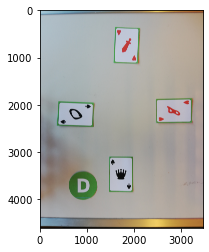

In [5]:
img_dir = "C:\\Users\\PC\\Desktop\\Image-Processing-Assignements\\Project\\train_games\\game1\\1.jpg"
img_test = plt.imread(img_dir)
plt.imshow(img_test)

The code given below is inspired from the one proposed here : https://towardsdatascience.com/image-processing-with-python-color-isolation-for-beginners-3b472293335b

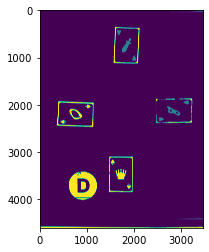

In [6]:
def red_color_isolation(img) : 
    output = img.copy()
    red_filtered = (output[:,:,0] > 150) & (output[:,:,1] < 100) & (output[:,:,2] < 110)
    output[:, :, 0] = output[:, :, 0] * red_filtered
    output[:, :, 1] = output[:, :, 1] * red_filtered
    output[:, :, 2] = output[:, :, 2] * red_filtered
    output = cv2.cvtColor(output, cv2.COLOR_BGR2HSV)
    plt.imshow(output[:,:,0])
    return output[:,:,0]

def green_color_isolation(img) : 
    output = img.copy()
    output = get_color_pixels(output,"green")
    return output

def black_color_isolation(img) : 
    output = img.copy()
    output = get_color_pixels(output,"black")
    return output

output_red = red_color_isolation(img_test)
output_green = green_color_isolation(img_test)
output_black = black_color_isolation(img_test)
output = output_red + output_green + output_black
plt.imshow(output)

Now that we have isolated everything, we can start to draw boxes around each motif

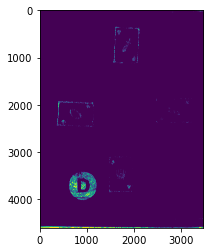

In [8]:
ret, thresh = cv2.threshold(output, 127, 255, 0)
cimg = output.copy()
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
boxes = cv2.drawContours(output, contours, 0, (0,255,0), 3)
plt.imshow(boxes)

circles = cv2.HoughCircles(output,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(cimg)